<a href="https://colab.research.google.com/github/ChristianVorage/DeepLearningPaperReproduction/blob/main/ReplicationCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproduction of: A Voxel Graph CNN for Object Classification with Event Cameras

## 1. Import Package Dependencies

In [ ]:
# Install wget for getting the data
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=126ee318822f3b6e4420783884fda0c785f421a02b97234eb356ef40e9546eee
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [ ]:
# For loading the data:
import zipfile
import wget

# For the actual computations:
import numpy as np
import math

# For the learning:
import torch
import torch.nn as nn

from sklearn.neighbors import NearestNeighbors

# Alex hacker stuff :)
from dataclasses import dataclass

# For visualisation:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## 2. Load the event data from their Google drive

In [ ]:
# Download from the N-Caltech public drive, https://drive.google.com/drive/folders/1sY91hL_iHnmfRXSTc058bfZ0GQcEC6St
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hr28hw9i9xOR_-KqdTB5aSbj2XkOdZVG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hr28hw9i9xOR_-KqdTB5aSbj2XkOdZVG" -O Data.zip && rm -rf /tmp/cookies.txt

--2023-04-16 15:49:12--  https://docs.google.com/uc?export=download&confirm=t&id=1hr28hw9i9xOR_-KqdTB5aSbj2XkOdZVG
Resolving docs.google.com (docs.google.com)... 108.177.127.102, 108.177.127.113, 108.177.127.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7fm1ei6fivs2qadhi3ugirukfleq78dm/1681660125000/06096567971161314749/*/1hr28hw9i9xOR_-KqdTB5aSbj2XkOdZVG?e=download&uuid=acb78cbc-142c-4520-b0a6-5ff536e2c464 [following]
--2023-04-16 15:49:13--  https://doc-0c-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7fm1ei6fivs2qadhi3ugirukfleq78dm/1681660125000/06096567971161314749/*/1hr28hw9i9xOR_-KqdTB5aSbj2XkOdZVG?e=download&uuid=acb78cbc-142c-4520-b0a6-5ff536e2c464
Resolving doc-0c-4s-docs.googleusercontent.com (doc-0c-4s-docs.googleusercontent.com)... 108.177.119.

Now load the specific content of the files, and extract the data into the content folder

In [ ]:
with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

## 3. Start the fun! First of all, load the data

> First of all, we have a bit of code to read the binary files, most of this is adapted from the code publicised in [the python 2.7 code](https://github.com/gorchard/event-Python/blob/master/eventvision.py) the researchers wrote for opening and reading the binary files of N-Cal.
> There is a handmade class that stores the events in readable format and does some preliminary operations.

In [ ]:
# Add a class that holds a set of events, and 
# provides some elementary manipulations:

@dataclass
class Events:
  x: np.array
  y: np.array
  t: np.array
  p: np.array

  def __init__(self, x: np.array, y: np.array, t: np.array, p: np.array):
    if len(x) != len(y) or len(y) != len(t) or len(t) != len(p):
      raise ValueError("The length of x, y, t, and p must be equal")

    self.x = x
    self.y = y
    self.t = t
    self.p = p

  
  def normalize_time(self, A):
    """Resize the time array to fit in the window [0, A]"""
    t0 = np.min(self.t)
    tN = np.max(self.t)

    self.t = (self.t - t0) * (A/(tN- t0))

  @property
  def length(self):
    return len(self.x)

In [ ]:
def read_dataset(filename):
    """Reads in the TD events contained in the N-MNIST/N-CALTECH101 dataset file specified by 'filename'"""
    f = open(filename, 'rb')
    raw_data = np.fromfile(f, dtype=np.uint8)
    f.close()
    raw_data = np.uint32(raw_data)

    all_y = raw_data[1::5]
    all_x = raw_data[0::5]
    all_p = (raw_data[2::5] & 128) >> 7  # bit 7
    all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])

    d = Events(all_x, all_y, all_ts, all_p)

    return d

Now lets use that code to load a dataset. In this case, a face.

In [ ]:
path = '/content/data/Caltech101/Faces_easy/image_0002.bin' 

data = read_dataset(path)
data

Events(x=array([124,  92,  94, ...,  29, 130,  47], dtype=uint32), y=array([  2, 166,  54, ..., 147,   3,  94], dtype=uint32), t=array([    35,    132,    134, ..., 299106, 299107, 299117], dtype=uint32), p=array([0, 1, 1, ..., 1, 1, 1], dtype=uint32))

This does not look like much yet if we show it all at once. To show it, we do need a function however:

In [ ]:
def create_3D_plot_from(events: Events):
  fig = plt.figure(figsize=(20,10))
  ax = plt.axes(projection='3d')

  p = ax.scatter3D(events.t, events.x, events.y, s= 1, c= events.p, cmap= 'viridis')

  ax.set_xlabel('Timestamp', fontsize=15)
  ax.set_ylabel('X-Coordinate Pixel', fontsize=15)
  ax.set_zlabel('Y-Coordinate Pixel', fontsize=15)
  ax.set_title('3D-Plot of Event Data', fontsize=25)
  
  fig.colorbar(p)
  
  plt.show()

Now, we can make the plot using this function:

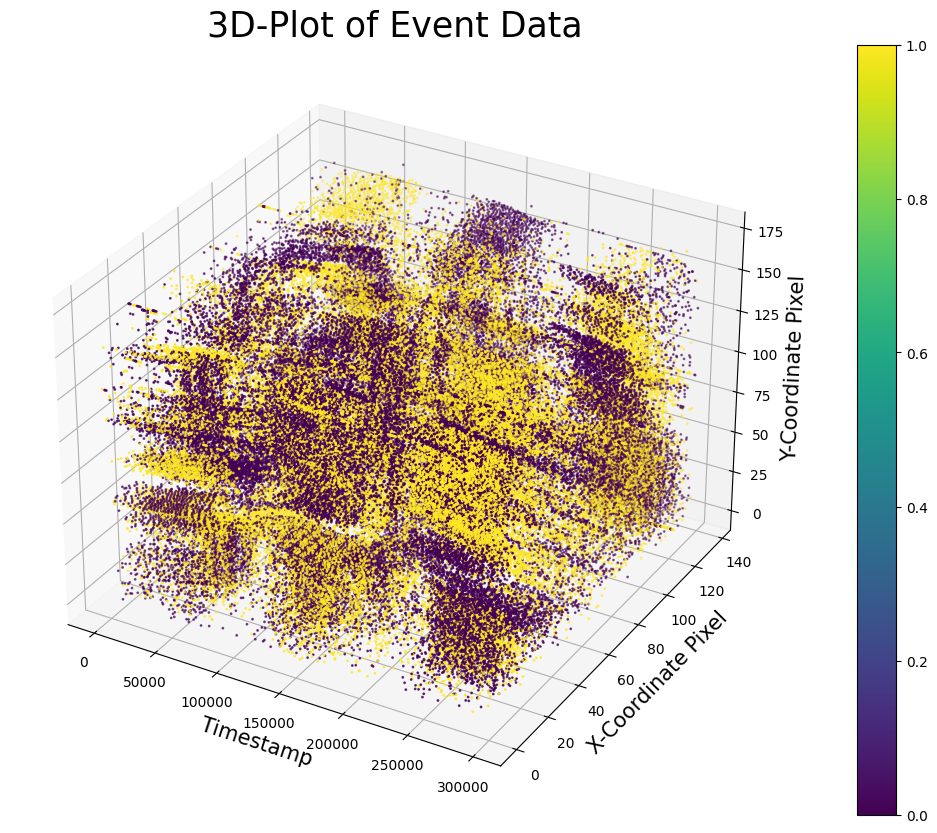

In [ ]:
create_3D_plot_from(data)

As we can see, although there seems to be some information, it is not obvious what it inside the picture at all

## 3. Voxelisation, Vertex selection and Feature Calculation

In [ ]:
# We need a way to consistently set the size of the voxels, 
# thus a class is born to capture this:

@dataclass
class VoxelSize:
  """
    This dataclass shapes and regularizes the form of the VoxelSize
  """
  x: np.uint32 = 5
  y: np.uint32 = 5
  t: np.uint32 = 3

voxel_size = VoxelSize(5, 5, 3)

In [ ]:
# We also need a class which represents a voxel:

@dataclass
class Voxel:
  """
    This class represents a voxel, including its information
  """
  x: np.uint32 
  y: np.uint32 
  t: np.uint32 
  voxel_size: VoxelSize
  _events: Events

  @property
  def events(self):
    return self._events

  @events.setter 
  def events(self, events: Events):
    self._features = None
    self._events = events

  @property
  def x_range(self):
    return (self.x, self.x+ self.voxel_size.x)

  @property
  def y_range(self):
    return (self.y, self.y + self.voxel_size.y)

  @property
  def t_range(self):
    return (self.t, self.t + self.voxel_size.t)

  @property
  def features(self):
    # Cache the features, so we do not have to recalculate
    if self._features is not None:
      return self._features
    
    features = np.zeros((self.voxel_size.x, self.voxel_size.y),)
    for i in range(self.voxel_size.x):
      for j in range(self.voxel_size.y):
        xk = self.x + i
        yk = self.y + j

        events_ = (self.events.x == xk) & (self.events.y == yk)

        # A bit of a hacky way to resolve numpy's itch to cast a bool to a uint
        # That was a bug that caused an underflow error when subtracting one,
        # which meant that you would get features of size 1.e10 or so
        features[i, j] = np.sum(-1*(self.events.p[events_]*-2 + 1) * 
                                (self.events.t[events_]))
        
    self._features = np.ravel(features)
    return self._features

In [ ]:
def in_range(arr: np.array, range: tuple):
  return (arr >= range[0]) & (arr < range[1])

In [ ]:
def plot_list_of_voxels_in_3D(list_of_voxels):
  plot_data = np.array(tuple((voxel.x, voxel.y, voxel.t, voxel.events.length) 
        for voxel in list_of_voxels))

  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111, projection='3d')

  p = ax.scatter3D(plot_data[:,2], plot_data[:,0], plot_data[:,1],
                   s= 50, c= plot_data[:,3], cmap='viridis', marker='s')

  ax.set_xlabel('Timestamp', fontsize=15)
  ax.set_ylabel('X-Coordinate Pixel', fontsize=15)
  ax.set_zlabel('Y-Coordinate Pixel', fontsize=15)
  ax.set_title('3D-Plot of Voxels', fontsize=25)
  
  fig.colorbar(p)
  
  plt.show()

In [ ]:
def voxelize_data(d, voxel_size: VoxelSize, Np = 2048, A = 9):

  d.normalize_time(A)

  height = np.max(d.y) + 1
  width  = np.max(d.x) + 1
  
  N_voxels_x = math.ceil(width / voxel_size.x)
  N_voxels_y = math.ceil(height / voxel_size.y)
  N_voxels_t = math.ceil(A / voxel_size.t)

  voxels = list()
  empty = np.zeros((0,))
  empty_event = Events(empty, empty, empty, empty)

  for i in range(N_voxels_x):
    for j in range(N_voxels_y):
      for k in range(N_voxels_t):
        voxel = Voxel(i* voxel_size.x, 
                      j* voxel_size.y, 
                      k* voxel_size.t, 
                      voxel_size,
                      empty_event,
        )
        x_range = voxel.x_range
        y_range = voxel.y_range
        t_range = voxel.t_range

        events_ = (in_range(d.x, x_range) & \
                   in_range(d.y, y_range)) & \
                   in_range(d.t, t_range)

        voxel.events = Events(d.x[events_],
                              d.y[events_],
                              d.t[events_] - voxel.t,
                              d.p[events_])
        
        voxels.append(voxel)  

  # Take the Np voxels with the most information: 
  voxels.sort(reverse = True, key = lambda voxel: voxel.events.length)
  voxels = voxels[:Np]

  return voxels


In [ ]:
voxels = voxelize_data(data, voxel_size)

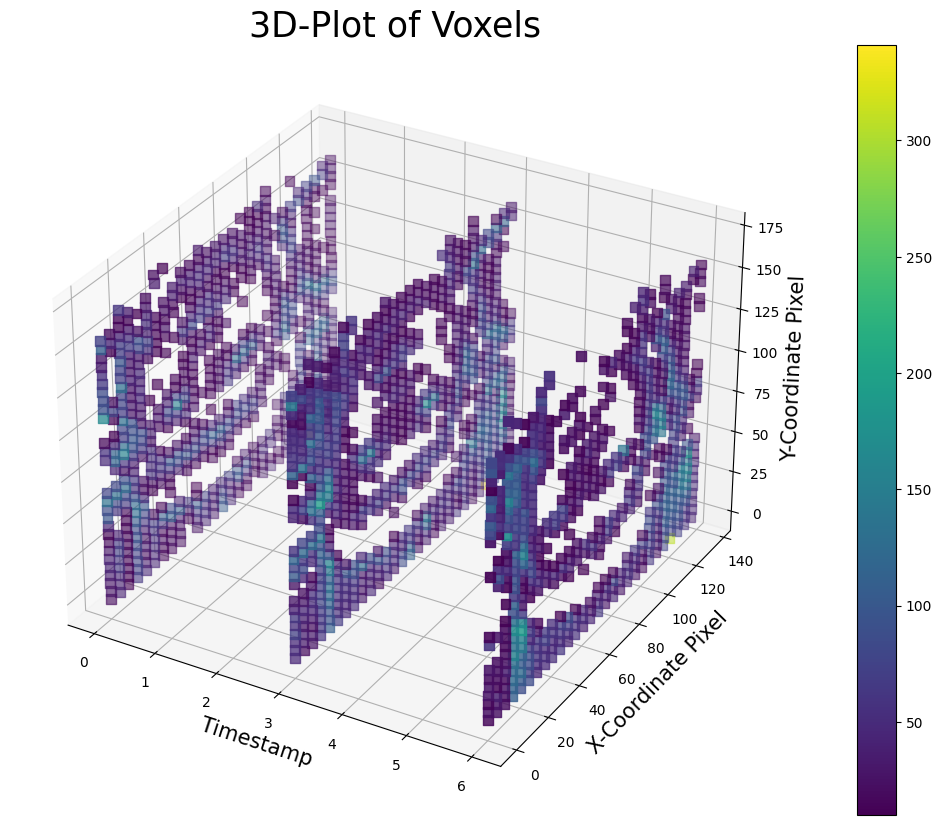

<ipython-input-18-99d79bedeac6>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  vertex_features = torch.Tensor(voxel_features).type(torch.FloatTensor)


In [ ]:
# Just for some nice sorted views:
voxels.sort(key = lambda voxel: (voxel.x, voxel.y, voxel.t))

plot_list_of_voxels_in_3D(voxels)

# Create tuples, which we will transform into vertexes
voxel_coordinates = tuple(((voxel.x, voxel.y, voxel.t) for voxel in voxels))
voxel_features = tuple((voxel.features for voxel in voxels))

# Convert them to torch FloatTensors
vertex_features = torch.Tensor(voxel_features).type(torch.FloatTensor)
vertex_coordinates = torch.Tensor(voxel_coordinates).type(torch.FloatTensor)

In [ ]:
def plot_features(features, N = 35):
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  p = ax.matshow(features[:N, :])
  fig.colorbar(p)
  plt.title("The first vertices with their features")
  plt.xlabel("The #th feature")
  plt.ylabel("The #th voxel")

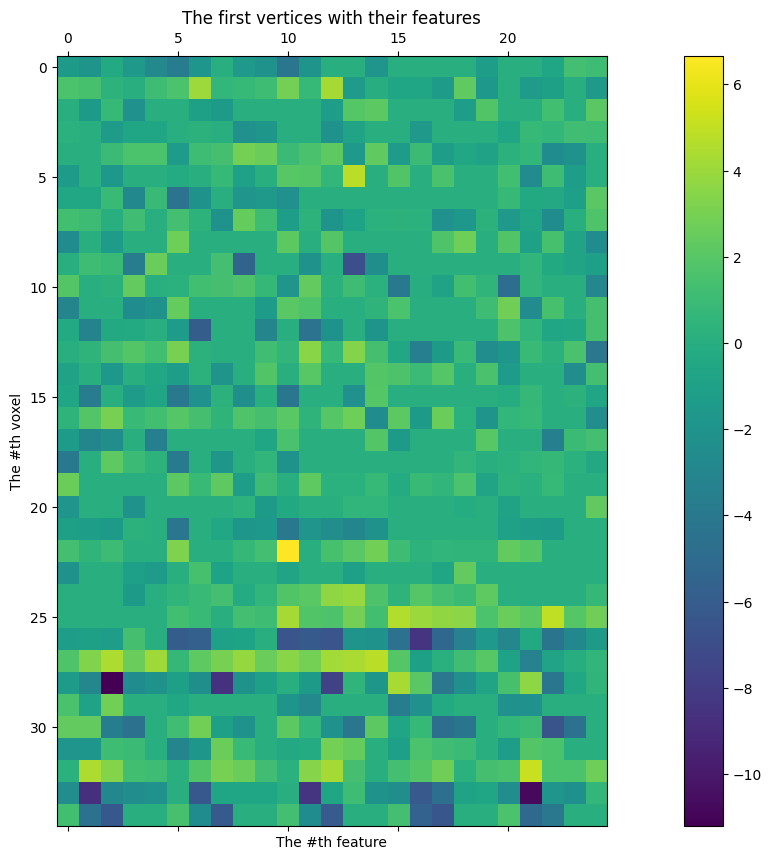

In [ ]:
plot_features(vertex_features)

In [ ]:
def subtract(arr1, arr2):
    return arr1 - arr2

subtract_vmap = torch.vmap(
        subtract,
        in_dims=(1, 0),
        out_dims=1,
)

In [ ]:
@torch.jit.script
def select_tensor_index(tensor, indices):
  return tensor[indices]

In [ ]:
# Test select_vmap:
print(select_tensor_index(vertex_coordinates, torch.Tensor([1,2]).type(torch.int64)))
vertex_coordinates.index_select(0, torch.Tensor([1, 2]).type(torch.int64))

tensor([[0., 0., 3.],
        [0., 0., 6.]])


tensor([[0., 0., 3.],
        [0., 0., 6.]])

In [ ]:
class SFRL(nn.Module):
  def __init__(self, D_in: int, D_out: int, number_of_neighbours: int):
    """SFRL

    This is a class representation of the SFRL of the paper

    GOALS:
      i)    Building connections among vertices and edges
      ii)   Computing scoring matrix for neighbors of the vertex
      iii)  Integrating features from the neigborhood for each vertex

    INPUTS:
      D_in: int, The amount of features passed into the SFRL     
      D_out: int, The amount of features each vertex has after application of the SFRL
      number_of_neigbours: int, The number of neighbours the SFRL considers

    OUTPUTS:
      SFRL
    """
    # Initialize as a Module:
    super().__init__()

    self._D_in = D_in 
    self._D_out = D_out

    self._number_of_neighbours = number_of_neighbours

    # All functions for Mi
    self.linear_m = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=6*number_of_neighbours,
            out_features=number_of_neighbours*number_of_neighbours
        ),
        nn.BatchNorm1d(num_features=number_of_neighbours*number_of_neighbours),
        nn.Tanh(),
        nn.Unflatten(1, (number_of_neighbours, number_of_neighbours))
    )

    # All functions for Fi
    self.linear_f = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            number_of_neighbours*D_in,
            number_of_neighbours*D_out
        ),
        nn.BatchNorm1d(
          number_of_neighbours*D_out
        ),
        nn.ReLU(),
        nn.Unflatten(1, (number_of_neighbours, D_out))
    )

    self.nearest_neighbours = NearestNeighbors(
        n_neighbors=number_of_neighbours, 
        algorithm='ball_tree')
    
    self.stack_coordinates = torch.vmap(
        self._stack_coordinates,
        in_dims=(None, 0, 0),
        out_dims=0
    )

    

  def forward(self, coordinates, features, show_KNN=False):
    N = coordinates.shape[0]

    neighbours = self.nearest_neighbours.fit(coordinates)
    distances, indices = neighbours.kneighbors(coordinates)
    self_coordinates = torch.tensor(
            [range(coordinates.shape[0])]
            ).type(torch.int64).ravel()


      # Optional Displaying KNN in 3D-space
    if show_KNN == True:
      fig = plt.figure(figsize=(10,8))
      ax = plt.axes(projection='3d')

      chosen_index = N//2
      indices_slice = indices[chosen_index,:]
      ax.scatter3D(coordinates[:,0], coordinates[:,1], coordinates[:,2], color="g",s=1) 
      ax.scatter3D(coordinates[chosen_index,0], coordinates[chosen_index,1], coordinates[chosen_index,2], color="b",s=25)  
      ax.scatter3D(coordinates[indices_slice,0], coordinates[indices_slice,1], coordinates[indices_slice,2], color="r",s=20)
      ax.set_title('K-Nearest Neighbours Clustering')
      ax.set_ylabel('y-coordinate of pixel')
      ax.set_xlabel('x-coordinate of pixel')
      ax.set_zlabel('time index: t')
      ax.zaxis.labelpad = 0
      ax.legend(["All Vertices", "Vertex of Interest", "KNN of Vertex of Interest"])
      plt.show()

    neighbour_indices = torch.from_numpy(indices)

    stacked_coordinates = self.stack_coordinates(
          coordinates, 
          neighbour_indices, 
          self_coordinates
    )

    M = self.linear_m(stacked_coordinates)

    F = features.index_select(0,neighbour_indices.ravel())
    F = F.reshape((N ,self._number_of_neighbours, self._D_in))

    F = self.linear_f(F)

    return torch.sum(torch.matmul(M, F), dim=1)

  @staticmethod
  def _stack_coordinates(coordinates, neighbour_indices, self_index):
    # Select the indices of self using the jit compiler
    self_coordinates = select_tensor_index(coordinates, self_index)

    # Select the neighbours per batch
    neighbour_coordinates = coordinates.index_select(0, neighbour_indices)

    # Return the combined vector of self coordinates and their distance    
    return torch.concat((neighbour_coordinates, subtract_vmap(neighbour_coordinates, self_coordinates)), dim=1)
  



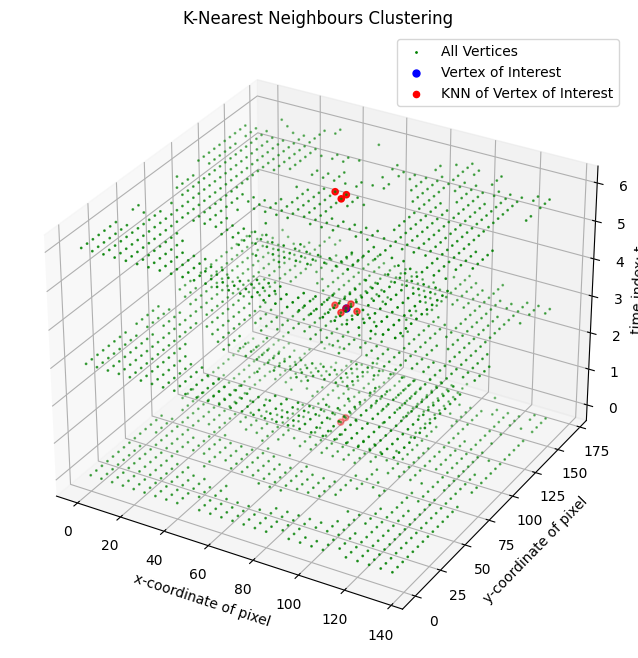

tensor([[-1.7472,  2.0221,  1.4477,  ..., -2.4802, -0.2887,  2.9454],
        [ 0.4147,  0.4700,  3.3773,  ...,  3.9175, -2.5010,  0.2649],
        [-0.1266, -1.0906, -5.4579,  ..., -1.9668, -3.3866,  4.1059],
        ...,
        [ 4.7280,  2.9069,  0.9462,  ..., -3.8757, 13.0900, -3.7749],
        [-7.6326, 10.4698, -0.8691,  ..., -4.1060, -5.8148,  6.3864],
        [-0.0461, -8.5338, -1.0541,  ...,  6.1846, -7.9327, -5.1083]],
       grad_fn=<SumBackward1>)


In [ ]:
sfrl = SFRL(25, 40, 10)

print(sfrl.forward(vertex_coordinates, vertex_features, True))

In [ ]:
class MFRL(nn.Module):
  def __init__(self, 
               D_in, 
               D_out, 
               number_of_neighbours_adjecent = 10, 
               number_of_neighbours_distant  = 15,
    ):
    """
    A class supporting an implementation of a MFRL

    INPUTS:
      D_in: int, the amount of input features
      D_out: int, the amount of output features 
      number_of_neighbours_adjecent: int, 10, 
          the amount of adjecent neighbours including oneself. 
          Set to ten in accordance to the paper
      number_of_neighbours_distant: in, 15
          the amount of distant neighbours including oneself.
          Set to fifteen in accordance to the paper

    OUTPUTS:
      The MFRL implementation
    """
    super().__init__()

    self._D_in = D_in
    self._D_out = D_out
    self.number_of_neighbours_adjecent = number_of_neighbours_adjecent
    self.number_of_neighbours_distant = number_of_neighbours_distant
    
    self.sfrl_adjecent = SFRL(D_in, D_out, number_of_neighbours_adjecent)
    self.sfrl_distant = SFRL(D_in, D_out, number_of_neighbours_distant)

    self.nonlinear_pass_through = nn.Sequential(
        nn.Linear(D_in, D_out),
        nn.BatchNorm1d(D_out),
        nn.ReLU()
    )

  def forward(self, coordinates, features):
    adjecent = self.sfrl_adjecent.forward(coordinates, features)
    distant = self.sfrl_distant.forward(coordinates, features)
    passthrough = self.nonlinear_pass_through(features)

    return coordinates, adjecent + distant + passthrough

In [ ]:
mfrl = MFRL(25, 40)

output = mfrl.forward(vertex_coordinates, vertex_features)
torch.gradient(output[1])

(tensor([[-9.4835e+00, -7.4551e-01, -3.4808e-01,  ..., -1.0823e+00,
           4.1632e+00,  5.3432e+00],
         [-7.0394e-01,  4.1268e-01, -1.6177e+00,  ...,  8.4796e-01,
           7.8039e-01,  4.0253e+00],
         [-8.1992e-01,  1.3456e+00,  5.5300e-03,  ..., -1.2504e+00,
          -2.8562e+00, -2.7266e+00],
         ...,
         [-7.8732e+00, -1.8735e+00, -7.3619e+00,  ...,  1.5389e+01,
           4.7326e+00, -1.6208e+00],
         [-2.9401e+00,  1.1918e+00, -5.1043e+00,  ...,  2.3235e+00,
          -3.9688e-01,  3.0309e+00],
         [-2.2448e+00,  3.8670e+00,  5.2969e+00,  ..., -1.8252e+01,
          -7.1496e+00, -5.5220e-01]], grad_fn=<CatBackward0>),
 tensor([[-4.5474, -3.4507, -0.6297,  ..., -3.0538, -1.7808, -3.8935],
         [ 4.1906,  1.1170, -1.1981,  ...,  1.8387,  1.4320, -2.7135],
         [-2.3141, -4.3645, -1.7095,  ...,  0.8511,  1.3965,  2.5962],
         ...,
         [ 6.3998,  7.9602, -4.3583,  ..., -1.0150, -0.3250, -3.3967],
         [ 8.5518,  2.0253, -3.0

In [ ]:
class GraphPool(nn.Module):
  def __init__(self, number_of_nodes_out):
    """A super simple model that just selects and outputs  number_of_nodes_out of different different nodes from the list randomly"""
    super().__init__()

    self.number_of_nodes_out = number_of_nodes_out

  def forward(self, coordinates, features):
    N = coordinates.shape[0]

    if N < self.number_of_nodes_out:
      raise ValueError("The number of nodes in must be higher or equal to the number of nodes out. IN: {}, OUT: {}".format(N, self.number_of_nodes_out))

    selected_rows = torch.randperm(N)[:self.number_of_nodes_out]

    return coordinates[selected_rows], features[selected_rows]

In [ ]:
gp = GraphPool(20)

gp.forward(vertex_coordinates, vertex_features)

(tensor([[125.,  40.,   3.],
         [ 30.,  70.,   6.],
         [  0.,  30.,   3.],
         [130., 140.,   3.],
         [120.,  70.,   0.],
         [120., 130.,   0.],
         [ 65., 155.,   0.],
         [115., 130.,   6.],
         [ 70., 110.,   6.],
         [ 70., 145.,   0.],
         [ 20.,  95.,   3.],
         [ 70., 160.,   0.],
         [ 90.,   0.,   6.],
         [ 75.,  50.,   0.],
         [115.,  10.,   0.],
         [  0.,  85.,   0.],
         [115., 105.,   3.],
         [120., 120.,   3.],
         [ 25.,  30.,   0.],
         [ 30., 105.,   0.]]),
 tensor([[  0.0000,   0.0000,   0.0000,  -1.9475,  -0.4721,  -0.4397,  -0.4392,
           -2.5584,  -1.0829,  -1.8662,  -2.1910,  -2.0477,  -4.1058,  -2.1707,
           -2.1596,  -4.1017,  -3.2274,  -2.7294,  -2.7637,  -2.9123,  -1.2352,
           -1.4250,  -0.6966,  -2.8835,  -1.1446],
         [  1.5139,   2.8456,   2.4291,   1.9753,   0.0000,   0.0000,   2.4486,
            1.8459,   1.8854,   0.0000,   0.000

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    """
    Classifier class
    """
    # Initialize as a Module:
    super().__init__()

    self.three_layers = nn.Sequential( 
        ### Three fully connected layers  ###
        # Layer 1:
        nn.Linear(in_features = 1024, out_features = 512, bias=True),
        nn.LeakyReLU(negative_slope = 0.01),
        nn.BatchNorm1d(num_features = 512),
        nn.Dropout(p=0.5),
        # Layer 2:
        nn.Linear(in_features = 512, out_features = 256, bias=True),
        nn.LeakyReLU(negative_slope = 0.01),
        nn.BatchNorm1d(num_features = 256),    
        nn.Dropout(p=0.5),
        # Layer 3:
        nn.Linear(in_features = 256, out_features = 101, bias=True),
        nn.Softmax(dim=0),
        )

  def forward(self, input):
      """
      INPUTS:
        input: Data; vertices by features [N_r x 512]
      
      OUTPUTS:
        prediction: Output label of network [101]
      """
      ### Apply Symmetry Functions --> Max & Average Pooling ###:
      # Max pooling
      mp, mp_idx = torch.max(input, dim=1)

      # Average pooling
      ap = torch.mean(input, dim=1)

      # Concatenate result
      res = torch.cat((mp, ap), dim=1)

      # Pass result through three layer network:
      prediction = self.three_layers(res)

      return prediction

B = 32 # Batch size
Nr = 50 # Features
D_in = 512
dummy_coords = np.random.uniform(low=0.0, high=1.0, size=(Nr,3))
dummy_features = np.random.uniform(low=0.0, high=1.0, size=(B,Nr,D_in))
dummy_features_tensor = torch.tensor(dummy_features, dtype=torch.float32)

clf = Classifier()

pred = clf.forward(dummy_features_tensor)
print(pred.shape)
print(pred)

torch.Size([32, 101])
tensor([[0.0116, 0.0305, 0.1240,  ..., 0.0248, 0.0254, 0.0801],
        [0.0507, 0.0420, 0.0116,  ..., 0.1057, 0.0993, 0.0103],
        [0.0140, 0.0050, 0.0088,  ..., 0.0148, 0.0213, 0.0104],
        ...,
        [0.0246, 0.0220, 0.0214,  ..., 0.0052, 0.0156, 0.0142],
        [0.0489, 0.0026, 0.0200,  ..., 0.0459, 0.0283, 0.0513],
        [0.0188, 0.0044, 0.0201,  ..., 0.0204, 0.0367, 0.0189]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
class EV_GCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.mfrl1 = MFRL(25, 64)
    self.gp1 = GraphPool(896)
    
    self.mfrl2 = MFRL(64, 64)
    self.gp2 = GraphPool(786)

    self.mfrl3 = MFRL(64, 128)
    self.gp3 = GraphPool(680)

    self.mfrl4 = MFRL(128, 128)

    self.nonlinear_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            128,
            512
        ),
        nn.BatchNorm1d(
          512
        ),
        nn.ReLU()
    )

    self.classifier = Classifier()

  def forward(self, coordinates, features):
    ffeatures = torch.zeros((coordinates.shape[0], 680, 512))
    for i in range(coordinates.shape[0]):
      coords, feats = self.mfrl1.forward(coordinates[i], features[i])
      coords, feats = self.gp1.forward(coords, feats)
      coords, feats = self.mfrl2.forward(coords, feats)
      coords, feats = self.gp2.forward(coords, feats)
      coords, feats = self.mfrl3.forward(coords, feats)
      coords, feats = self.gp3.forward(coords, feats)
      coords, feats = self.mfrl4.forward(coords, feats)
      feats = self.nonlinear_block(feats)
      ffeatures[i] = feats
    
    return self.classifier(ffeatures)
    
  

In [ ]:
evgcnn = EV_GCNN()
sum(p.numel() for p in evgcnn.parameters())

10758217

In [ ]:
# Download from the N-Caltech public drive, https://drive.google.com/file/d/1ROqpHBAYqaPHlMnScDtC3eKNhIjEpEpT/view?usp=share_link
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/file/d/1ROqpHBAYqaPHlMnScDtC3eKNhIjEpEpT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ROqpHBAYqaPHlMnScDtC3eKNhIjEpEpT" -O PreProcessed.zip && rm -rf /tmp/cookies.txt

with zipfile.ZipFile('PreProcessed.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

--2023-04-16 15:51:54--  https://docs.google.com/uc?export=download&confirm=&id=1ROqpHBAYqaPHlMnScDtC3eKNhIjEpEpT
Resolving docs.google.com (docs.google.com)... 108.177.127.100, 108.177.127.102, 108.177.127.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/dlmlh5aopbkp21geaujnrj02v5r6n3ld/55k6eumcpfqj0463rqj54b5u2jlb1tu0/1681660275000/10004492103429576393/04675622392464745881Z/1ROqpHBAYqaPHlMnScDtC3eKNhIjEpEpT?e=download&uuid=7c3f8e9c-6d81-4866-b619-73bff1823e37 [following]
--2023-04-16 15:51:55--  https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/dlmlh5aopbkp21geaujnrj02v5r6n3ld/55k6eumcpfqj0463rqj54b5u2jlb1tu0/1681660275000/10004492103429576393/04675622392464745881Z/1ROqpHBAYqaPHlMnScDtC3eKNhIjEpEpT?e=download&uuid=7c3f8e9c-6d81-4866-b619-73bff1823e37
Resolving doc-0k-1c-docs.googleusercontent.com (doc-0k-1c-docs

In [ ]:
class DataLoader:
  def __init__(self, labelDict, indices, batch_size):
    self.labelDict = labelDict
    self.indices = indices
    self.N = len(indices)
    self.batch_size = batch_size

    self.sorted_keys = sorted(list((set(labelDict.keys()) - set(['total']))))

    keys_and_values = tuple(labelDict.items())

    self.labels = {}
    self.files = {}

    indices = set(indices)

    for key, rng in keys_and_values:
      if key == 'total':
        break

      finished_indices = set(self.labels.keys())
      to_do_indices = indices - finished_indices
      
      for index in to_do_indices:
        if index in rng:
          index = int(index)
          self.labels[index] = key
          index2 = index - labelDict[key].start
          string = self.convertIntToString(int(index2)+1)
          self.files[index] = np.load(f'/content/Caltech101Preprocessed/{key}/image_{string}.npz')
    
  def load_data_by_index(self, indices):
    coordinates = torch.zeros((len(indices), 2048, 3))
    features = torch.zeros((len(indices), 2048, 25))

    labels = []
    for i, idx in enumerate(indices):
      idx = int(idx)
      f = self.files[idx]
      label = self.find_i_corresponding_to_label(self.labels[idx])
      labels.append(label)
      fcoordinates = f['vertex_coordinates']
      coordinates[i, :fcoordinates.shape[0], :] = torch.from_numpy(
          fcoordinates
      )

      ffeatures = f['vertex_features']
      features[i, :ffeatures.shape[0], :] = torch.from_numpy(
          ffeatures
      )

    return coordinates, features, self.createOneHotTensor(labels)

  @staticmethod
  def createOneHotTensor(ind):
    n = len(ind)
    out = torch.zeros(n, 101)
    out[range(n), ind] = 1
    return out

  def iterate(self,):
    self.shuffle_indices()
    batch_indices = self.create_batches()

    return (self.load_data_by_index(batch_index) for batch_index in batch_indices)

  def find_i_corresponding_to_label(self, label):
    # Assume that the label is in the list
    return self.find_in_sorted_list(label, self.sorted_keys)

  @staticmethod
  def find_in_sorted_list(elem, sorted_list):
    import bisect
    # https://docs.python.org/3/library/bisect.html
    'Locate the leftmost value exactly equal to x'
    i = bisect.bisect_left(sorted_list, elem)
    if i != len(sorted_list) and sorted_list[i] == elem:
        return i
    return -1

  def shuffle_indices(self,):
    new_permutation = torch.randperm(self.N)
    self.indices = self.indices[new_permutation]

  def create_batches(self,):
    return self.indices[:(self.N//self.batch_size)*self.batch_size].reshape((self.N//self.batch_size, self.batch_size))

  @staticmethod
  def convertIntToString(i):
    s = str(i)
    while len(s) < 4:
        s = "0" + s
    return s
  
    

In [ ]:
import pickle

# Load pickled labelDict
with open("/content/Caltech101Preprocessed/labelsDict.pickle", "rb") as f:
  labelDict = pickle.load(f)

labelDict

{'elephant': range(0, 64),
 'cougar_body': range(64, 111),
 'pyramid': range(111, 168),
 'lotus': range(168, 234),
 'platypus': range(234, 268),
 'Leopards': range(268, 468),
 'llama': range(468, 546),
 'binocular': range(546, 579),
 'dragonfly': range(579, 647),
 'yin_yang': range(647, 707),
 'saxophone': range(707, 747),
 'headphone': range(747, 789),
 'ferry': range(789, 856),
 'gerenuk': range(856, 890),
 'stop_sign': range(890, 954),
 'starfish': range(954, 1040),
 'brain': range(1040, 1138),
 'strawberry': range(1138, 1173),
 'crab': range(1173, 1246),
 'brontosaurus': range(1246, 1289),
 'nautilus': range(1289, 1344),
 'cougar_face': range(1344, 1413),
 'watch': range(1413, 1652),
 'barrel': range(1652, 1699),
 'euphonium': range(1699, 1763),
 'laptop': range(1763, 1844),
 'metronome': range(1844, 1876),
 'beaver': range(1876, 1922),
 'rhino': range(1922, 1981),
 'snoopy': range(1981, 2016),
 'mayfly': range(2016, 2056),
 'scissors': range(2056, 2095),
 'rooster': range(2095, 21

In [ ]:
ind = torch.randperm(labelDict['total'].stop)
d = DataLoader(labelDict, ind, 3)

for i in d.iterate():
  print((torch.argmax(i[2], 1)== torch.tensor([0, 1,1])))

tensor([False, False, False])
tensor([False,  True, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False,  True, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False,  True, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([ True, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([ True, False, False])
tensor([False, False, False])
tensor([False, False, False])
tensor([Fa

In [ ]:
# Split data in validation data, and normal data randomly, with 80% in train data, and 20 percent in validation data
N = labelDict['total'].stop
split_point = int(N*0.8)
permutation = torch.randperm(N)
train_idxs = permutation[:split_point]
val_idxs = permutation[split_point:]

train_loader = DataLoader(labelDict, train_idxs, 20)
test_loader = DataLoader(labelDict, val_idxs, 20)

In [ ]:
@torch.no_grad()
def evaluate_error(dataLoader, net, loss_fn, error_fn, test_data=True):
  running_loss_test = 0.0
  running_error_test = 0.0
  datatype = "test" if test_data else "training"

  for idx, (coordinates, features, labels) in enumerate(dataLoader.iterate()):
        y_pred = net(coordinates, features)

        loss_test = loss_fn(y_pred, labels)
        error_test = error_fn(y_pred, labels)
        running_loss_test += loss_test.item()
        running_error_test += error_test.item()
  print(
      f"Loss on {datatype} data: {running_loss_test / idx:.3f}, Prediction error of model on {datatype} data: {running_error_test / idx:.3f}"
  )
  return running_error_test / idx

In [ ]:
@torch.no_grad()
def evaluate_accuracy(dataLoader, net):
  correct = 0
  t = 0

  for idx, (coordinates, features, labels) in enumerate(dataLoader.iterate()):
    y_pred = net(coordinates, features)

    correct += sum(torch.argmax(y_pred, 1) == torch.argmax(labels, 1))
    t += y_pred.shape[0]

  return correct/t * 100

In [ ]:
# Training Setup
import time

# Hyperparameters
num_epochs = 250
learning_rate = 0.1
batch_size = 32

# Initialize network
net = EV_GCNN()
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer,
                                                      T_max = num_epochs, ## could be different
                                                      eta_min = 1e-6)
criterion = nn.CrossEntropyLoss()
error_fn = nn.L1Loss()

# Split data in validation data, and normal data randomly, with 80% in train data, and 20 percent in validation data
N = labelDict['total'].stop
split_point = int(N*0.8)
permutation = torch.randperm(N)
train_idxs = permutation[:split_point]
val_idxs = permutation[split_point:]

train_loader = DataLoader(labelDict, train_idxs, batch_size)
test_loader = DataLoader(labelDict, val_idxs, batch_size)

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []
train_errors = []
test_errors = [] 

# # Try using gpu instead of cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for epoch in range(num_epochs):

    # # Network in training mode and to device
    net.train()
    net.to(device)
    a = time.time()

    # Training loop
    for idx, (coordinates, features, labels) in enumerate(train_loader.iterate()):
        # Set the gradients to zero
        optimizer.zero_grad()

        coordinates.to(device)
        features.to(device)
        labels.to(device)

        # Perform forward pass
        y_pred = net(coordinates, features)
        
        # Compute the loss
        loss = criterion(y_pred, labels)
        train_losses.append(loss.item())
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

        print(f"step {idx} done")

    # Compute train and test error
    train_error = evaluate_error(train_loader, net.to('cpu'), criterion, error_fn, test_data=False)
    test_error = evaluate_error(test_loader, net.to('cpu'), criterion, error_fn, test_data=True)
    
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Compute train and test accuracy:
    train_acc=  evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = evaluate_accuracy(test_loader, net.to('cpu'))

    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print(f'Time taken {time.time()-a}')
    print('')

Streaming output truncated to the last 5000 lines.
step 147 done
step 148 done
step 149 done
step 150 done
step 151 done
step 152 done
step 153 done
step 154 done
step 155 done
step 156 done
step 157 done
step 158 done
step 159 done
step 160 done
step 161 done
step 162 done
step 163 done
step 164 done
step 165 done
step 166 done
step 167 done
step 168 done
step 169 done
step 170 done
step 171 done
step 172 done
step 173 done
step 174 done
step 175 done
step 176 done
step 177 done
step 178 done
step 179 done
step 180 done
step 181 done
step 182 done
step 183 done
step 184 done
step 185 done
step 186 done
step 187 done
step 188 done
step 189 done
step 190 done
step 191 done
step 192 done
step 193 done
step 194 done
step 195 done
step 196 done
step 197 done
step 198 done
step 199 done
step 200 done
step 201 done
step 202 done
step 203 done
step 204 done
step 205 done
step 206 done
step 207 done
step 208 done
step 209 done
step 210 done
step 211 done
step 212 done
step 213 done
step 214 do

In [ ]:
import gc 
gc.collect()